In [94]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [95]:
def load_and_process_data(probability, total_time):
    # Get list of relevant files first
    files = [f for f in os.listdir('../simulation_results') 
             if f.startswith(f'realization_{probability}_') and f.endswith('_vel.csv')]

    # Pre-allocate list with known size
    dfs = [None] * len(files)

    for i, file in enumerate(files):
        # Extract realization ID from filename
        realization_id = file.split('_')[2]
        
        # Read the CSV
        temp_df = pd.read_csv(os.path.join('../simulation_results', file))
        
        # If simulation ended early, calculate all new rows at once
        if temp_df['Time'].max() < total_time:
            timestep = temp_df['Time'].iloc[1]
            last_row = temp_df.iloc[-1]
            
            # Calculate all new time points
            new_times = np.arange(temp_df['Time'].max() + timestep, total_time + timestep, timestep)
            
            # Create DataFrame of new rows efficiently
            new_rows = pd.DataFrame([last_row] * len(new_times))
            new_rows['Time'] = new_times
            
            # Concatenate once
            temp_df = pd.concat([temp_df, new_rows], ignore_index=True)
        
        # Add realization ID column
        temp_df['realization'] = realization_id
        dfs[i] = temp_df

    # Combine all dataframes at once
    df = pd.concat(dfs, ignore_index=True)
    # Time, zombiePercentage, averageVelocity as float
    df['Time'] = df['Time'].astype(float)
    df['Time'] = df['Time'].round(2)
    df['zombiePercentage'] = df['zombiePercentage'].astype(float)
    df['averageVelocity'] = df['averageVelocity'].astype(float)

    # realization as int
    df['realization'] = df['realization'].astype(int)

    # print df columns types
    print('Probability: ', probability, '\nTotal Time: ', total_time)
    
    return df

In [96]:
fontsize = 14
linewidth = 2

def plot_zombie_percentage_over_time(df):
    # Graficar el porcentaje de zombis en función del tiempo para todas las realizaciones
    for realization in df['realization'].unique():
        realization_data = df[df['realization'] == realization]
        plt.plot(realization_data['Time'], realization_data['zombiePercentage'], 
                label=f'Realización {realization}')

    plt.xlabel('Tiempo (s)', fontsize=fontsize)
    plt.ylabel('Porcentaje de Zombies (%)', fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.show()

    # Plot the mean zombiePercentage over time
def plot_mean_zombie_percentage_over_time(df):
    # Time repeated in the dataframe over realizations. Should be unique and the zombiePercentage should be the mean of all realizations at that time.
    grouped = df.groupby('Time')['zombiePercentage'].mean()
    sem = df.groupby('Time')['zombiePercentage'].sem()
    plt.plot(grouped.index, grouped.values, 'g-', linewidth=linewidth)

    # Add error bands
    plt.fill_between(grouped.index, grouped.values - sem, grouped.values + sem, alpha=0.3, color='g')

    plt.xlabel('Tiempo (s)', fontsize=fontsize)
    plt.ylabel('Porcentaje de Zombies (%)', fontsize=fontsize)
    plt.show()

Probability:  0.5 
Total Time:  1000


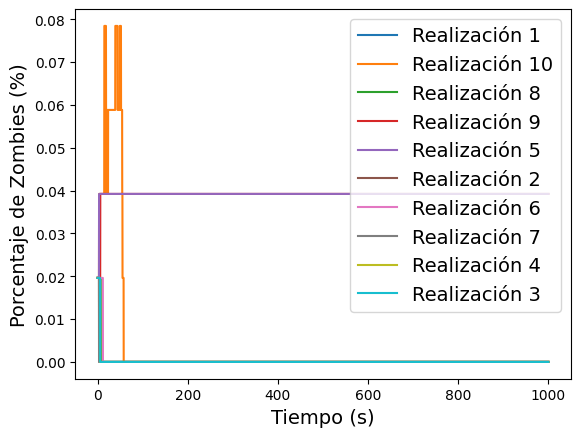

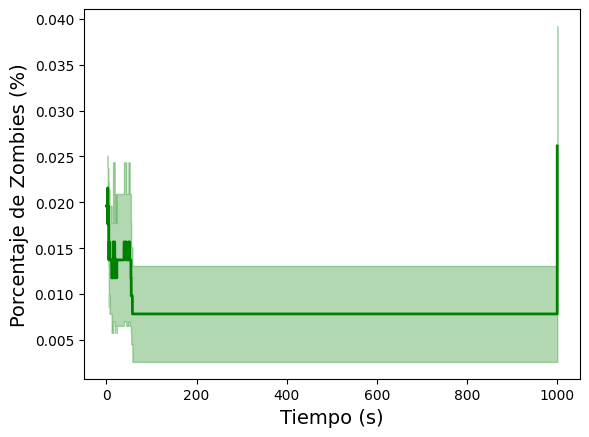

In [97]:
df = load_and_process_data('0.5', 1000)
plot_zombie_percentage_over_time(df)
plot_mean_zombie_percentage_over_time(df)

Probability:  0.6 
Total Time:  1000


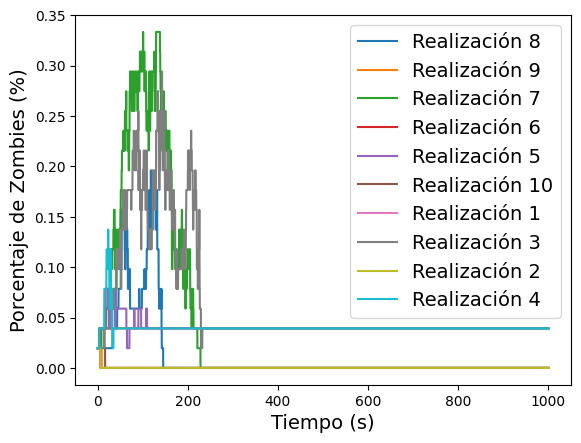

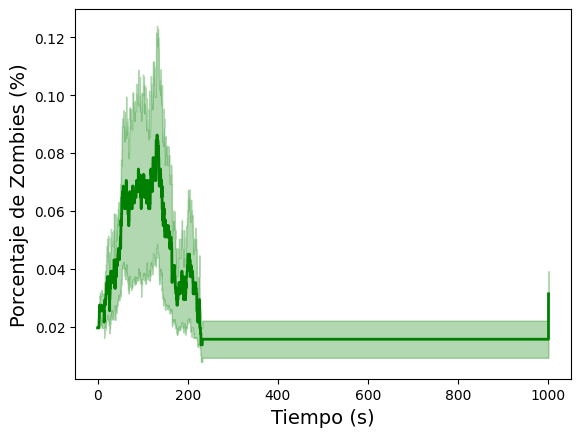

In [98]:
df = load_and_process_data('0.6', 1000)
plot_zombie_percentage_over_time(df)
plot_mean_zombie_percentage_over_time(df)

Probability:  0.7 
Total Time:  1000


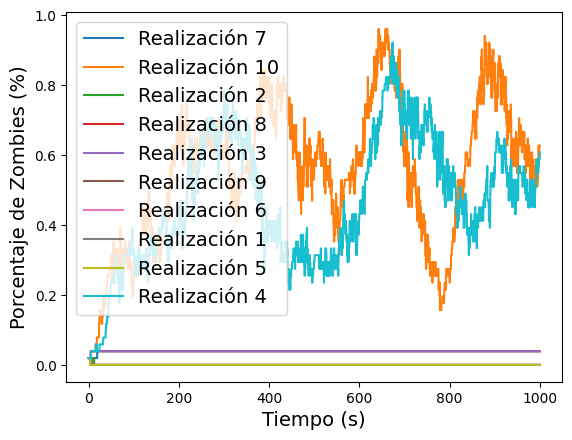

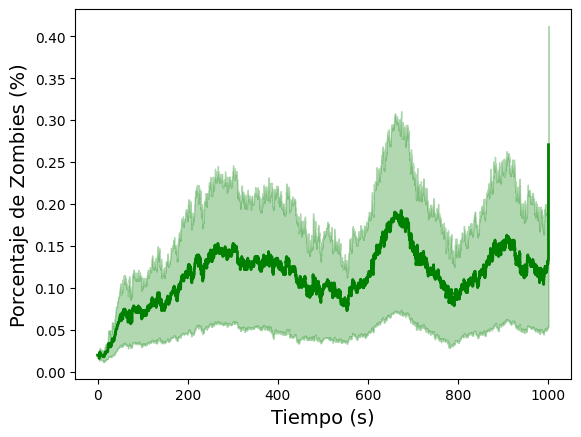

In [99]:
df = load_and_process_data('0.7', 1000)
plot_zombie_percentage_over_time(df)
plot_mean_zombie_percentage_over_time(df)

Probability:  0.8 
Total Time:  1000


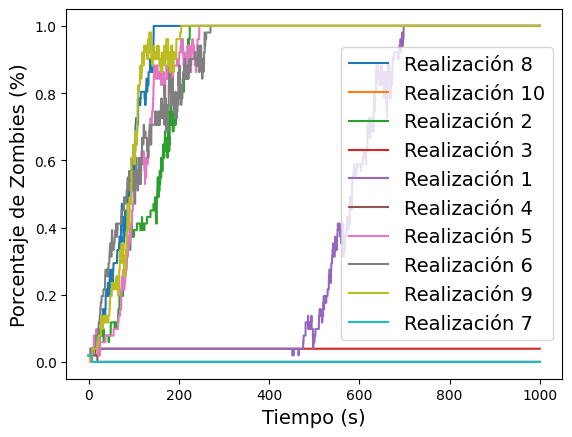

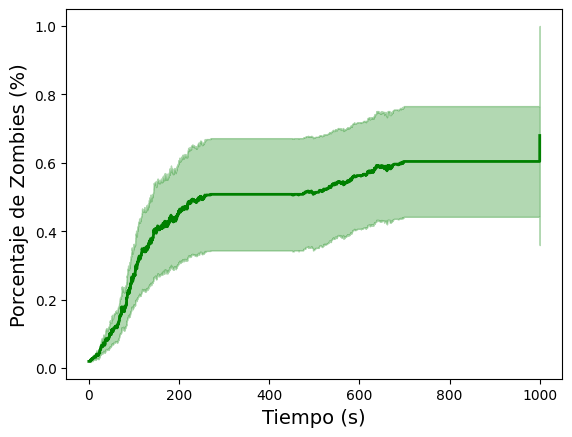

In [100]:
df = load_and_process_data('0.8', 1000)
plot_zombie_percentage_over_time(df)
plot_mean_zombie_percentage_over_time(df)